Date: 26/12/2020

# Building a Deep Neural Network from scratch.

This project focuses on building a Deep Neural Network from scratch. The aim of this project is to : -<br>
1) Understand the concepts and working of DNN.<br>
2) Using ReLU.<br>
3) Coding it.<br>

## Import Modules

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy
%matplotlib inline

## Import Data

In [2]:
raw_train_data = h5py.File('train_catvnoncat.h5')

In [3]:
train_keys = list(raw_train_data.keys())

In [4]:
X_train_raw = np.array(raw_train_data[train_keys[1]])
y_train_raw = np.array(raw_train_data[train_keys[2]])

classes = np.array(raw_train_data[train_keys[0]])

In [7]:
print(f'The shape of X_train_raw is:{X_train_raw.shape}')
print(f'The shape of y_train_raw is:{y_train_raw.shape}')

The shape of X_train_raw is:(209, 64, 64, 3)
The shape of y_train_raw is:(209,)


In [8]:
y_train = y_train_raw.reshape((1, y_train_raw.shape[0]))

print(f'The shape of y_train is:{y_train.shape}')

The shape of y_train is:(1, 209)


In [12]:
X_train = X_train_raw.reshape((X_train_raw.shape[0], -1)).T

print(f'The shape of X_train is:{X_train.shape}')

The shape of X_train is:(12288, 209)


## Normalization

In [11]:
X_train = X_train/255.0

## Model development

In [110]:
'''
Defining number of units in each layers.

Inputs: -
------
units_in_layers - Number of units for each layer in the form of a list. 

Output: -
------
Prints number of units in each layer.
'''

units_in_layers = [X_train.shape[0], 5, 1]
total_layers = len(units_in_layers)

print('Number of units in each layers are:')

for i in range(len(units_in_layers)):
    print(str(i) + f' layer has {units_in_layers[i]} units')

print('---------------------------------------------------')
print(f'Total number of layers are {total_layers}')

Number of units in each layers are:
0 layer has 3 units
1 layer has 5 units
2 layer has 1 units
---------------------------------------------------
Total number of layers are 3


In [95]:
def initialization_func(units_in_layers, total_layers):
    '''
    This function initializes weights and bias for the layers.
    
    Inputs: -
    ------
    units_in_layers - Number of units for each layer in the form of a list. 
    total_layers - Total number of layers.

    Returns: -
    ------
    weights - dictionary containing weights and bias.
    '''
    
    np.random.seed(5)
    weights = {}
    
    for i in range(1, total_layers):
        weights['W' + str(i)] = np.random.randn(units_in_layers[i], 
                                                units_in_layers[i - 1])*0.01
        weights['b' + str(i)] = np.zeros((units_in_layers[i], 
                                                    1))
    
    return weights

In [96]:
def forward_activation(A_ref, W, b, activation):
    '''
    Implements the forward propagation and calculates the required Activation.
    
    Inputs: -
    ------
    A_ref - Activations from previous layer (Initially it is equal to the input data). 
    W - Weight associated with the corresponding layer.
    b - Bias associated with the corresponding layer.
    activation - Name of the activation function to be implemented.

    Returns: -
    ------
    a - Activation value for the next layer.
    forward_cache - List containing values of A_ref, W, b, Z which is used during 
                    backward propagation. 
                    Example: - For initial layer the forward_cache will be
                    forward_cache = (A_ref 0, W1, b1 z1)
                    0 --> refers to the input layer or activation values of the previous layer.
                    1 --> refers to the values associated with the 1st layer.
    '''
    
    if activation == 'sigmoid':
        z = np.matmul(W, A_ref) + b
        a = 1/(1 + np.exp(-z))
        forward_cache = (A_ref, W, b, z)
        return a, forward_cache
    
    elif activation == 'relu':
        z = np.matmul(W, A_ref) + b
        a = np.maximum(0, z)
        forward_cache = (A_ref, W, b, z)
        return a, forward_cache

In [97]:
def backward_activation_sigmoid(z):
    '''
    Calculates the derivative of sigmoid activation.
    
    Inputs: -
    ------
    z - Forward propagation value. This value is collected from **forward_cache**
        of **forward_activation** function.

    Returns: -
    ------
    Derivative of sigmoid function.
    '''
    
    sig = 1/(1 + np.exp(-z))
        
    return sig*(1 - sig)
    
def backward_activation_relu(z):
    '''
    Calculates the derivative of ReLU activation.
    
    Inputs: -
    ------
    z - Forward propagation value. This value is collected from **forward_cache**
        of **forward_activation** function.

    Returns: -
    ------
    Derivative of ReLU function.
    '''
        
    relu_grad = z.copy()         
    relu_grad[relu_grad <= 0] = 0
    relu_grad[relu_grad > 0] = 1

    return relu_grad 

In [189]:
def forward_prop_func(weights, X_train):
    '''
    Implements the forward propagation and calculates the Activation for every layer.
    
    Inputs: -
    ------
    weights - Initial weights calculated from **initialization_func** function.
    X_train - Input data.

    Returns: -
    ------
    A_last - Activation value of the last layer.
    cache - List of tuples containing the values of A_ref, W, b, Z of every layer.
    '''
    
    L = len(list(weights.keys()))//2
    A_ref = X_train.copy()
    cache = []
    
    for i in range(L - 1):
        A_next, forward_cache = forward_activation(A_ref, weights['W' + str(i + 1)],
                                                  weights['b' + str(i + 1)], activation = 'relu')
        A_ref = A_next
        cache.append(forward_cache)
    
    A_last, forward_cache = forward_activation(A_ref, weights['W' + str(L)],
                                               weights['b' + str(L)], activation = 'sigmoid')
    cache.append(forward_cache)
    
    return A_last, cache

In [99]:
def cost_func(A_last, y_train):
    '''
    Calculates the cost for a given value of weights.
    
    Inputs: -
    ------
    A_last - Activation value of the last layer calculated 
             from **forward_prop_func** function.
    y_train - Label data.

    Returns: -
    ------
    train_cost - Training cost for a given value of weights.
    dA_last - Derivative of Loss with respect to the last activation layer.
    '''
    
    epsilon = 1e-5
    train_cost = (-(y_train*np.log(A_last + epsilon) + 
             (1 - y_train)*np.log(1 - A_last + epsilon))).mean()
    
    dA_last = (-(np.divide(y_train, A_last + epsilon)
               - np.divide((1 - y_train), (1 - A_last + epsilon))))
    
    return train_cost, dA_last

In [100]:
def dZ_func(dA_last, Z, activation):
    '''
    Calculates derivative of Loss with respect to the forward propagation layer.
    
    Inputs: -
    ------
    dA_last - Derivative of Loss with respect to the last activation layer.
              This value is collected from **cost_func** function.
    Z - This value is collected from **forward_cache** of **forward_activation** function.
    activation - Name of the activation function to be implemented.

    Returns: -
    ------
    dZ values.
    '''
    
    if activation == 'relu':
        return dA_last*backward_activation_relu(Z)
    
    elif activation == 'sigmoid':
        return dA_last*backward_activation_sigmoid(Z)

In [129]:
def grad(cache, dA_last, activation):
    '''
    Calculates gradients.
    
    Inputs: -
    ------
    cache - List of tuples containing the values of A_ref, W, b, Z of every layer.
    dA_last - Derivative of Loss with respect to the last activation layer.
              This value is collected from **cost_func** function.
    activation - Name of the activation function to be implemented.

    Returns: -
    ------
    dA_prev - Derivative of Loss with respect to the previous activation layer.
    dw_ - Weight gradient.
    db_ - Bias gradient.
    '''
    
    A_prev, W, b, Z = cache
    m = A_prev.shape[1]
    
    dz = dZ_func(dA_last, Z, activation)
    dw_ = (1.0/m)*np.matmul(dz, A_prev.T)
    db_ = (1.0/m)*(dz).sum(axis = 1, keepdims = True)
    dA_prev = np.matmul(W.T, dz)
    
    return dA_prev, dw_, db_     

In [102]:
def back_prop_func(A_last, cache, y_train):
    '''
    Calculates gradients.
    
    Inputs: -
    ------
    A_last - Activation value of the last layer calculated 
             from **forward_prop_func** function.
    cache - List of tuples containing the values of A_ref, W, b, Z of every layer.
    y_train - Label data.

    Returns: -
    ------
    grads - Dictionary of gradients.
    train_cost - Value of training cost.
    '''
    
    grads = {}
    L = len(cache)
    

    train_cost, dA_last = cost_func(A_last, y_train)
    
    current_cache = cache[-1]
    dA_temp, dw_temp, db_temp = grad(current_cache, dA_last, activation = 'sigmoid')
    grads['dA' + str(L)] = dA_temp
    grads['dW' + str(L)] = dw_temp
    grads['dB' + str(L)] = db_temp
    
    for t in reversed(range(L - 1)):
        current_cache = cache[t]
        grads['dA' + str(t + 1)], grads['dW' + str(t + 1)], grads['dB' + str(t + 1)] = grad(current_cache, grads['dA' + str(t + 2)], activation = 'relu')

    return grads, train_cost

In [ ]:
def update_parameters(weights, grads, learning_rate):
    '''
    Updates the weights.
    
    Inputs: -
    ------
    weights - Dictionary containing weights and bias.
    grads - Dictionary of gradients. This value is collected from **back_prop_func**.
    learning_rate - Value of learning rate.

    Returns: -
    ------
    Updated values of weights.
    '''
    
    lr = learning_rate
    L = len(weights) // 2
    
    for l in range(L):
        weights["W" + str(l+1)] = weights["W" + str(l+1)] - lr* grads["dW" + str(l+1)]
        weights["b" + str(l+1)] = weights["b" + str(l+1)] - lr * grads["dB" + str(l+1)]
        
    return weights

## Final Model

In [104]:
def nn_model(units_in_layers, total_layers, X_train, y_train,
             iterations, learning_rate):
    '''
    Final model.
    
    Inputs: -
    ------
    units_in_layers - Number of units for each layer in the form of a list. 
    total_layers - Total number of layers.
    X_train - Input data.
    y_train - Label data.
    iterations - Iteration for optimization loop.
    learning_rate - Value of learning rate.

    Returns: -
    ------
    weights - Learned weights.
    training_cost - List of training cost.
    '''
    
    weights = initialization_func(units_in_layers, total_layers)
    training_cost = []
    
    for i in range(iterations):
        A_last_calc, cache = forward_prop_func(weights, X_train, X_test)
        grads, train_cost = back_prop_func(A_last_calc, cache, y_train)
        weights = update_parameters(weights, grads, learning_rate)
        
        
        if i%200 == 0:
            training_cost.append(train_cost)
            
    return weights, training_cost

## Model checking

In [174]:
units_in_layers = [X_train.shape[0], 500, 5, 1]
total_layers = len(units_in_layers)

u, co = nn_model(units_in_layers, total_layers, X_train, y_train,
             X_test, y_test, 3000, 0.01)


In [179]:
final_weights = u
training_cost = co

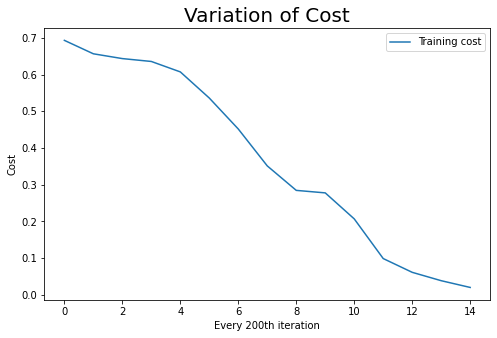

In [188]:
# Plotting the cost

plt.figure(figsize = (8, 5))
plt.plot(training_cost, label = 'Training cost')
plt.title('Variation of Cost', fontsize = 20)
plt.xlabel('Every 200th iteration')
plt.ylabel('Cost')
plt.legend()
plt.show()

# Conclusion

The Deep Neural Network code is running correctly and it is capable of reducing the cost.